# Run your first Serverless workload remotely

This section explores how to list programs available in Serverless, pass inputs into these programs, run them remotely, check their status, and retrieve results and logs.

Be sure you have authenticated to Qiskit Serverless with your [IBM Quantum account](https://quantum.ibm.com/account) (see [Deploy to IBM Quantum Platform](./serverless-first-program#deploy-to-ibm-quantum-platform) for instructions).

## List programs available

You can use [`ServerlessClient.list()`](https://qiskit.github.io/qiskit-serverless/stubs/qiskit_serverless.core.ServerlessClient.html#qiskit_serverless.core.ServerlessClient) to print out a list of the available programs to run with Qiskit Serverless.

In [1]:
from qiskit_serverless import IBMServerlessClient
serverless = IBMServerlessClient()
serverless.list()

[QiskitFunction(transpile_remote_serverless)]

## Run an uploaded program and pass inputs

First, set up your inputs. Your program has three inputs: `circuits`, `backend`, and `optimization_level`. You can use `random_circuit` to create 30 random circuits:

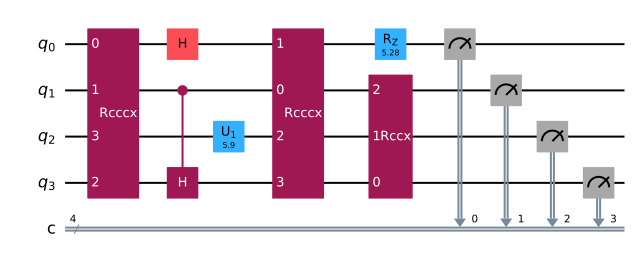

In [4]:
from qiskit.circuit.random import random_circuit

qc_random = [(random_circuit(4, 4, measure=True)) for _ in range(30)]
qc_random[0].draw(output='mpl', idle_wires=False)

Next, use `QiskitRuntimeService` and `least_busy` to select a `backend`:

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(backend.name)

ibm_nazca


Set your optimization level:

In [6]:
optimization_level = 3

Select your program with `serverless.get('PROGRAM_NAME')`:

In [ ]:
transpile_remote_serverless = serverless.get('transpile_remote_serverless')

Next, pass your inputs and run it in a pythonic fashion as follows:

In [ ]:
job = transpile_remote_serverless.run(
    circuits=qc_random,
    backend=backend.name,
    optimization_level=optimization_level
)

In [ ]:
job.job_id

'727e921d-512d-4b7d-af97-fe29e93ce7ea'

## Check job status

With your Qiskit Serverless `job_id`, you can check the status of running jobs. This includes the following statuses:

- **`QUEUED`**: The remote program is in the Qiskit Serverless queue. The queue priority is currently based on how much you've used Qiskit Serverless
- **`INITIALIZING`**: The remote program is starting; this includes setting up the remote environment and installing dependencies
- **`RUNNING`**: The program is running. At this stage, if you have `print()` outputs in your program, you should be able to retrieve logs using `job.logs()`
- **`DONE`**: The program is complete, and you can retrieve data stored in `save_result()` with `job.results()`

In [5]:
job.status()

'QUEUED'

## Retrieve logs and results

As mentioned before, once a program is `RUNNING`, you can use `job.logs()` to fetch logs created from `print()` outputs:

In [67]:
logs = job.logs()
print(logs)

No logs yet.


Once a program is `DONE`, you can use `job.results()` to fetch the result stored in `save_result()`:

In [48]:
result = job.result()
print(result)

{}


At any time, you can also cancel a job:

In [11]:
job.stop()

'Job has been stopped.'

## List previously run jobs run with Serverless

You can use `get_jobs()` to list all jobs submitted to Qiskit Serverless:

In [4]:
old_jobs = serverless.get_jobs()
old_jobs

[<Job | 90e1109e-809f-4768-a2dc-f45bf71a97b4>,
 <Job | 313050f2-aa78-4d7d-99f4-44bdfe98e4d7>]

You've successfully run your first Qiskit Serverless program. Next, you can explore [compute and data management tools](./serverless-manage-resources) available to your program, including parallelization.

## Next steps

<Admonition type="info" title="Recommendations">

- Read how to [manage Qiskit Serverless compute and data resources](./serverless-manage-resources).

</Admonition>